In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from scipy.optimize import curve_fit

import os, inspect

SMALL_SIZE = 20
MEDIUM_SIZE = 24
BIGGER_SIZE = 26

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=12)  # fontsize of the figure title


In [8]:
# Possible models to fit. 
def _linear_model(x, a=0.5):
    return np.ones(len(x))*a

def _exponential_model(x, a=1, k=0.1):
    return a * np.exp(-k * x)

#def _exponential_model(x, k=0.1):
#    return np.exp(-k * x)

def read_list_file(list_file,to_drop=[]):
    """
    Load a sparky .list file. Return residue number and peak height.
    
    list_file: sparky .list file
    to_drop: list of "Assignment" to drop (i.e. "?-?")
    
    returns dataframe with residue, height
    """
    
    # Load file
    df = pd.read_fwf(list_file)
    
    # Drop duplicants and nans
    df = df.drop_duplicates()
    df = df.dropna()

    # Drop anthing with assignment == something in to_drop
    for drop in to_drop:
        df = df.drop(df[df["Assignment"]== drop].index)
        
    # Get residue number and height
    df["residue"] = [int(v.split("N-H")[0][1:])
                     for v in df.Assignment.values]
    df["height"] = df["Data Height"]

    # Return dataframe with only residue and height
    return df.loc[:,["residue","height"]]

def normalize(df,cutoff=2e5,manual_max=2e6,force_fast=[79,98,99,113],force_max_to_one=None):
    """
    Normalize a set of heights for peaks to first peak. 
    
    df: dataframe for single residue with time and height columns. normalizes
        to height of first column.
    cutoff: if maximum height is less than this, assume no real signal. 
    manual_max: if lower than cutoff, normalize to manual max
    force_fast: for residues in list, force to be fast (normalize to manual_max
                and set as fast).
                
    returns: dataframe with time, residue, normalized signal, height, and flag
    where flag is "fast" or "unknown".
    """

    time = []
    norm = []
    height = []
    residue = []
    flag = []
    for i in np.unique(df.residue):

        t = np.array(df.loc[df.residue == i,:].time)
        h = np.array(df.loc[df.residue == i,:].height)
        
        if np.max(h) < cutoff or i in force_fast:
            n = h/manual_max
        else:
            n = h/np.max(h)
        
        # Drop first point
        n = n[1:]
        t = t[1:]
        h = h[1:]
        
        # For specific residues to normalize to one
        if force_max_to_one is not None:
            if i in force_max_to_one:
                n = n/np.max(n)

        time.extend(t)
        norm.extend(n)
        height.extend(h)
        residue.extend([i for _ in range(len(t))])
            
        if np.max(h) < cutoff or i in force_fast:
            flag.extend(["fast" for _ in range(len(t))])
        else:
            flag.extend(["unknown" for _ in range(len(t))])
            
        
    return pd.DataFrame({"time":time,
                         "residue":residue,
                         "norm":norm,
                         "height":height,
                         "flag":flag})

def load_hdx_expt(data_dir,
                  to_drop=["?-?","W88NE1-HE1"],
                  cutoff=2e5,
                  manual_max=2e6,
                  force_fast=[79,98,99,113],
                  force_max_to_one=[]):
    """
    Load an HDX experiment from data_dir. Assumes data_dir has timepoint.xlsx
    and .list files. The .list files contain peaks and peak heights for each
    timepoint. timepoint.xlsx gives the time at which each .list file was
    collected.
    
    data_dir: directory with timepoint.xlsx and list files
    to_drop: list of "Assignment" to drop (i.e. "?-?")
    cutoff: if maximum height is less than this, assume no real signal when 
            normalizing. 
    manual_max: if max height lower than cutoff, normalize to manual max
    force_fast: for residues in list, force to be fast (normalize to manual_max
                and set as fast).
    
    returns: dataframe with time, residue, norm, height, and flag.
    """
    
    # Get list of timepoints and data files
    df = pd.read_excel(os.path.join(data_dir,"timepoints.xlsx"))
    
    # Load datafiles and map timepoints
    df_list = []
    for i in range(len(df)):
        row = df.iloc[i]
        df_list.append(read_list_file(os.path.join(data_dir,row.file),
                                      to_drop=to_drop))
        df_list[-1]["time"] = row.time_in_minutes

    # Return single dataframe with all results
    final_df = pd.concat(df_list,ignore_index=True)
    
    for r in np.unique(final_df.residue):
        this_df = final_df.loc[final_df.residue == r,:]
        h = np.array(this_df.height)

    final_df = final_df.loc[:,["time","residue","height"]]
    
    return normalize(final_df,cutoff=cutoff,force_max_to_one=force_max_to_one)


        
def fit_hdx_aic(df,sigma2=0.00001,fig=None,ax=None,color="black"):
    """
    Fit a model to HDX data stored in df. Uses an AIC test to 
    decide what sort of model to fit. 
    
    df: dataframe with with "time", "norm" and "flag" columns.
    sigma2: squared error estimate for each normalized value (mainly affects
            AIC test, with smaller values promoting more complicated model 
            selection). 
    fig: fig on which to plot (if None, create)
    ax: ax on which to plot (if fig is None, will be created)
    color: color for plot series.

    returns: 
    """

    # Dictionary of models. 
    models = {"linear":_linear_model,
              "exponential":_exponential_model}
    
    # Get time and norm values
    t = np.array(df["time"],dtype=float)
    h = np.array(df["norm"],dtype=float)
    
    # Only fit linear to fast exchanger -- drop possible exponential fit
    if df.flag.iloc[0] == "fast":
        models = {"linear":models["linear"]}
    
    # Fit each model available
    fits = []
    for m in models:
        
        model = models[m]
        
        # Get signature of model to get appropriate guesses. All parameters 
        # constrained to be between 1e-12 and np.inf. 
        param = dict(inspect.signature(model).parameters)

        bounds = [[],[]]
        guesses = []
        for p in param:
            if param[p].default != inspect._empty:
                guesses.append(param[p].default)
                bounds[0].append(1e-12)
                bounds[1].append(np.inf)
            
        # Try to fit model
        try:
            
            # Do fit
            opt, cov = curve_fit(model,t,h,
                                 p0=guesses,
                                 bounds=bounds,
                                 sigma=np.ones(len(t))*np.sqrt(sigma2))

            # Get num data points and num parameters
            n = len(df)
            k = len(opt)
            
            # calculate log likelihood
            vals = model(t, *opt)
            lnL = -0.5*(np.sum((h - vals)**2/sigma2 + np.log(sigma2)))
            
            # calculate AICc due to small sample size 
            # (https://en.wikipedia.org/wiki/Akaike_information_criterion)
            AIC = 2*k - 2*lnL + (2*(k**2) + 2*k)/(n - k - 1)
        
            # Get fit parameter error
            err = np.sqrt(np.diag(cov))

        # If fit fails, print but keep going
        except RuntimeError:
            err = f"could not fit {m}\n"
            print(err)
            continue
            
        # Record AIC, model, parameter names, estimates, and errors in list
        fits.append((AIC,m,list(param.keys()),opt,err))
    
    # Sort by AIC (low to high)
    fits.sort()
    
    # Get best scoring model 
    best = fits[0]
    
    # Create output dictionary keying parameter name to estimate and error
    param_out = {}
    for i in range(len(best[2][1:])):
        p = best[2][i+1]
        param_out[p] = (best[3][i],best[4][i])

    # If fig/ax not passed, create new ones
    if fig is None:
        fig, ax = plt.subplots(1,figsize=(6,6))
        
    # Get model and parameter for plotting
    model = models[best[1]]
    param = best[3]
    
    # Plot fit
    x = np.linspace(0,np.max(df["time"])*1.1,1000)
    ax.scatter(df["time"],df["norm"],facecolor="none",edgecolor=color,s=40)
    ax.plot(x,model(x,*param),"-",lw=3,color=color)
   
    # Figure out what type of fit this is (exponential, fast, or slow). 
    flag = best[1]    
    if flag == "linear":
        if param_out["a"][0] < 0.1:
            flag = "fast"
        else:
            flag = "slow"
    
    
    return param_out, flag, fig, ax
    


could not fit exponential



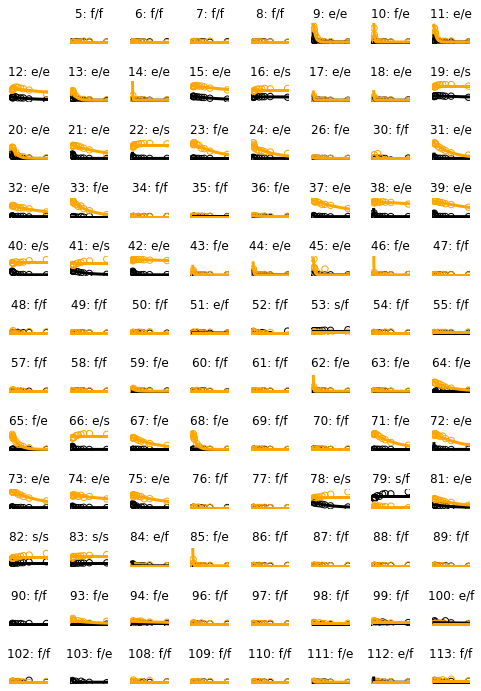

In [9]:
# Load data
a9 = load_hdx_expt("input-data/a9/",force_max_to_one=[79])
m63f = load_hdx_expt("input-data/m63f/",force_max_to_one=[38,39])

# Define figure size
fig_width=7
fig_height=10

# Figure out how many rows and columns to have to fit inside figure 
# dimensions gracefully
num_graphs = len(np.unique(a9.residue))
aspect_ratio = fig_width/fig_height
num_rows = np.sqrt(num_graphs/aspect_ratio)
num_rows = int(np.round(num_rows,0))
num_cols = int(np.ceil(num_graphs/num_rows))

label_reducer = {"exponential":"e",
                 "fast":"f",
                 "slow":"r"}

# Create plot
fig, ax = plt.subplots(num_rows,num_cols,figsize=(fig_width,fig_height))

# Find max/min for all plots
max_time = np.max((np.max(a9.time),np.max(m63f.time)))*1.05
min_height = np.min((np.min(a9.height),np.min(m63f.height)))*1.05
max_height = np.max((np.max(a9.height),np.max(m63f.height)))*1.05

# Get overall min/max for plots
xlim = (-100,max_time)
ylim = (-0.1,1.2)

# Dictionary will hold all output and be converted to a dataframe
out = {"residue":[],"protein":[],"flag":[],
       "a":[],"a_err":[],
       "k":[],"k_err":[]}

# Go through all unique residues in a9
row = 0
col = 0

# Make first empty so we can add axes in illustrator
ax[row,col].set_xlim(xlim)
ax[row,col].set_ylim(ylim)
ax[row,col].set_axis_off()

col += 1



for r in np.unique(a9.residue):
    
    # Fit A9 for this residue
    a9_df = a9.loc[a9.residue == r,:]
    if len(a9_df) > 0:
    
        param, flag, _, _ = fit_hdx_aic(a9_df,
                                        fig=fig,
                                        ax=ax[row,col],
                                        color="black")
        
        # New entry for this residue
        out["residue"].append(r)
        out["protein"].append("hS100A9")
        out["flag"].append(flag)
        out["a"].append(np.nan)
        out["a_err"].append(np.nan)
        out["k"].append(np.nan)
        out["k_err"].append(np.nan)
        
        # Populate parameters from the model that came out
        for p in param:
            out[p][-1] = param[p][0]
            out[f"{p}_err"][-1] = param[p][1]
        
    # Fig M63F for this residue
    m63f_df = m63f.loc[m63f.residue == r,:]
    if len(m63f_df) > 0:
        
        param, flag, _, _ = fit_hdx_aic(m63f_df,
                                        fig=fig,
                                        ax=ax[row,col],
                                        color="orange")
        # New entry for this residue
        out["residue"].append(r)
        out["protein"].append("hS100A9/M63F")
        out["flag"].append(flag)
        out["a"].append(np.nan)
        out["a_err"].append(np.nan)
        out["k"].append(np.nan)
        out["k_err"].append(np.nan)

        # Populate parameters from the model that came out
        for p in param:
            out[p][-1] = param[p][0]
            out[f"{p}_err"][-1] = param[p][1]
    
    # set plot limits etc.
    ax[row,col].set_xlim(xlim)
    ax[row,col].set_ylim(ylim)
    ax[row,col].set_title(f"{r}: {out['flag'][-2][0]}/{out['flag'][-1][0]}")
    ax[row,col].set_axis_off()
    
    # Incremet ax for fit
    col += 1
    if col == num_cols:
        row += 1
        col = 0
    
# Clear any remaining emtpy ax
while row < num_rows:
    ax[row,col].set_axis_off()
    col += 1
    if col == num_cols:
        row += 1
        col = 0
    
# Clean up as dispaly figure and write out
plt.tight_layout()
plt.savefig("figure_s3.pdf")

# Convert fit values to a dataframe
df = pd.DataFrame(out)


In [10]:
def compare_residues(df):
    """
    Compare the exchange for all residues seen in A9 and M63F. 
    
    df: dataframe output from cell above (residue, protein, flag, a, a_err, k, k_err)
    
    returns: dataframe with a row for each residue. columns hold qualitative 
             change (slower, faster, unchanged), quantitive change if calculable 
             (dlnK), quantitive error, and flags for A9 and M63F
    """

    # Lists to hold output for conversion to dataframe
    residue = []
    effect = []
    qualitative = []
    quantitative = []
    quant_err = []
    
    # Go through residues
    for r in np.unique(df.residue):

        residue.append(r)
        this_df = df.loc[df.residue == r]

        # Figure out effect (flag -> flag)
        if len(this_df) != 2:
            effect.append(("fast","missing"))
        else:
            effect.append((this_df.flag.iloc[0],
                           this_df.flag.iloc[1]))

        # For residues where both A9 and M63F fit, calculate ln(k2/k1) and 
        # error
        if "-".join(effect[-1]) == "exponential-exponential":

            # lnK1 is M63F. 
            lnK1 = np.log(this_df.k.iloc[1])
            
            # For error, subtract and add. For non-negative values,
            # take log. 
            e1u = this_df.k.iloc[1] + this_df.k_err.iloc[1]
            e1l = this_df.k.iloc[1] - this_df.k_err.iloc[1]
            estack = []
            if e1u > 0:
                estack.append(np.log(e1u))
            if e1l > 0:
                estack.append(np.log(e1l))

            # Final error is abs(lnK - mean_error)*1.96 --> 95% confidence
            e1 = np.abs(lnK1 - np.mean(estack))*1.96

            # lnK0 is A9. Repeat error as for M63F
            lnK0 = np.log(this_df.k.iloc[0])
            e0u = this_df.k.iloc[0] + this_df.k_err.iloc[0]
            e0l = this_df.k.iloc[0] - this_df.k_err.iloc[0]
            estack = []
            if e0u > 0:
                estack.append(np.log(e0u))
            if e0l > 0:
                estack.append(np.log(e0l))
            e0 = np.abs(lnK0 - np.mean(estack))*1.96

            # Record quantitative difference in lnK as well as propagated error
            quantitative.append(lnK1 - lnK0)
            quant_err.append(np.sqrt(e1**2 + e0**2))
        else:
            quantitative.append(np.nan)
            quant_err.append(np.nan)

        # Look for times when M63F is *slower* than A9, not quantitative
        if "-".join(effect[-1]) in ["fast-exponential",
                                    "exponential-slow",
                                    "fast-slow"]:
            qualitative.append("slower")
            
        # Look for times when M63F is *faster* than A9, not quantitative
        elif "-".join(effect[-1]) in ["slow-exponential",
                                      "exponential-fast",
                                      "slow-fast"]:
            qualitative.append("faster")
            
        # Map quantitative results to qualitative slower/faster axis
        elif "-".join(effect[-1]) == "exponential-exponential":
            if quantitative[-1] < 0:
                qualitative.append("slower")
            else:
                qualitative.append("faster")

        # No change 
        else:
            qualitative.append("unchanged")

    return pd.DataFrame({"residue":residue,
                         "qualitative":qualitative,
                         "quantitative":quantitative,
                         "quant_err":quant_err,
                         "a9":[e[0] for e in effect],
                         "m63f":[e[1] for e in effect]})


summary_df = compare_residues(df)
summary_df.to_csv("table_s5.csv")
summary_df

,residue,qualitative,quantitative,quant_err,a9,m63f
0,5,unchanged,NaN,NaN,fast,fast
1,6,unchanged,NaN,NaN,fast,fast
2,7,unchanged,NaN,NaN,fast,fast
3,8,unchanged,NaN,NaN,fast,fast
4,9,slower,-1.086609,0.010589,exponential,exponential
...,...,...,...,...,...,...
90,109,unchanged,NaN,NaN,fast,fast
91,110,unchanged,NaN,NaN,fast,fast
92,111,slower,NaN,NaN,fast,exponential
93,112,faster,NaN,NaN,exponential,fast


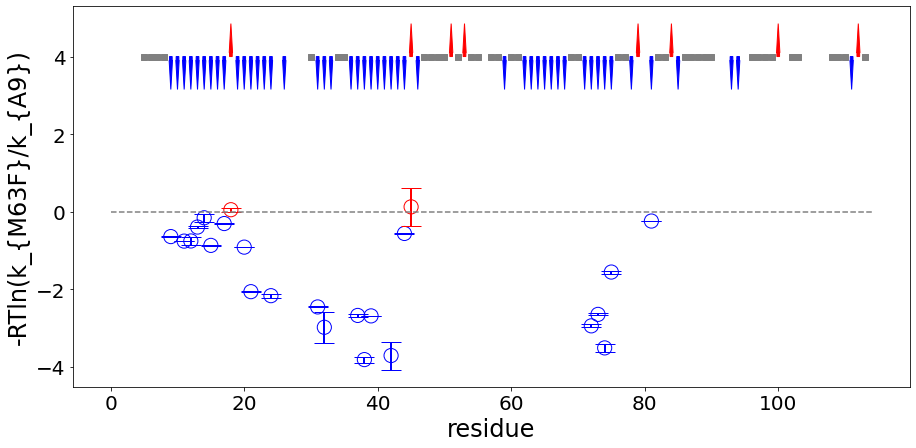

In [11]:
RT = 0.001987*298

fig, ax = plt.subplots(1,figsize=(15,7))

line_x = []
line_y = []
for r in np.unique(summary_df.residue):
    row = summary_df.loc[summary_df.residue == r,:].iloc[0]

    if row.qualitative == "slower":
        ax.arrow(r,4,0,-0.1,color="blue",head_width=.5,width=0.4)
        
        if np.logical_not(np.isnan(row.quantitative)):
            value = row.quantitative*RT
            ax.scatter(r,value,s=200,facecolor="none",edgecolor="blue")
            ax.errorbar(x=r,y=value,yerr=row.quant_err*RT,color="blue",capsize=10,lw=2)


    if row.qualitative == "faster":
        ax.arrow(r,4,0,0.1,color="red",head_width=.5,width=0.4)
        if np.logical_not(np.isnan(row.quantitative)):
            value = row.quantitative*RT
            ax.scatter(r,value,s=200,facecolor="none",edgecolor="red")
            ax.errorbar(x=r,y=value,yerr=row.quant_err*RT,color="red",capsize=10,lw=2)
            
    if row.qualitative == "unchanged":
        value = None
        ax.scatter(r,4,s=30,color="gray",marker="s")

    if value is not None:
        
        if len(line_x) > 0:
            if line_x[-1][-1] == (r - 1):
                line_x[-1].append(r)
                line_y[-1].append(value)
            else:
                line_x.append([r])
                line_y.append([value])
        else:
            line_x.append([r])
            line_y.append([value])
        
ax.plot((0,114),(0,0),"--",color="gray")
ax.set_xlabel("residue")
ax.set_ylabel("-RTln(k_{M63F}/k_{A9})")
fig.savefig("figure_s4b.pdf")

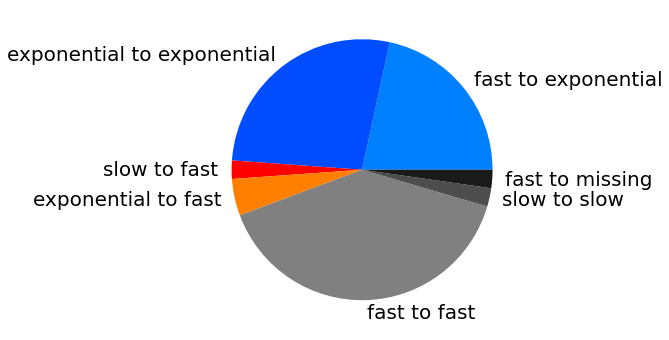

In [12]:
keys, values = np.unique([f"{a[0]}-{a[1]}" for a in zip(summary_df.a9,summary_df.m63f)],return_counts=True)

count_dict = dict(zip(keys,values))

labels = ["fast-exponential",
          "exponential-exponential",
          #"exponential-slow",
          "slow-fast",
          "exponential-fast",
          "fast-fast",
          "slow-slow",
          "fast-missing"]

color_map = {"fast-exponential":(0.,0.5,1),
             "exponential-exponential":(0.,0.3,1),
             "exponential-slow":(0.,0.1,1),
             "slow-fast":(1,0,0),    
             "exponential-fast":(1,0.5,0),
             "fast-fast":(0.5,0.5,0.5),
             "slow-slow":(0.3,0.3,0.3),
             "fast-missing":(0.1,0.1,0.1)}
             
fig, ax = plt.subplots(1,figsize=(6,6))

_ = ax.pie([count_dict[l] for l in labels],
           labels=[" to ".join(l.split("-")) for l in labels],
           colors=[color_map[l] for l in labels])

fig.savefig("figure_s4a.pdf")


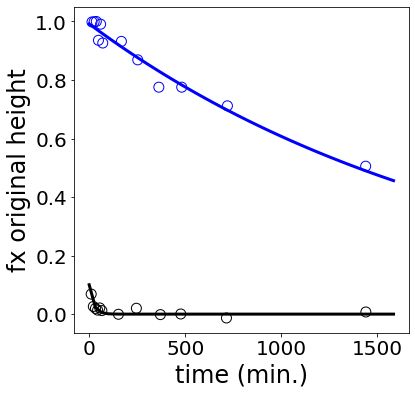

In [13]:
fig, ax = plt.subplots(1,figsize=(6,6))


markers = ["o","v","s","D"]
colors = [(0,0,1),(0.5,0.5,1),(0.7,0.7,1)]
for i, r in enumerate([37]): 
    a9_r = a9.loc[a9.residue == r,:]
    m63f_r = m63f.loc[m63f.residue == r,:]
        
    
        
    fit_values = df.loc[df.residue == r,:]
    
    ax.scatter(a9_r.time,a9_r.norm,s=100,facecolor="none",edgecolor="black",marker=markers[i])
    ax.scatter(m63f_r.time,m63f_r.norm,s=100,facecolor="none",edgecolor=colors[i],marker=markers[i])
    
    t = np.linspace(0,np.max(a9_r.time)*1.1)
    ax.plot(t,_exponential_model(t,fit_values.a.iloc[0],fit_values.k.iloc[0]),color="black",lw=3)
    ax.plot(t,_exponential_model(t,fit_values.a.iloc[1],fit_values.k.iloc[1]),color=colors[i],lw=3)
    #ax.plot(t,_exponential_model(t,fit_values.k.iloc[0]),color="black",lw=3)
    #ax.plot(t,_exponential_model(t,fit_values.k.iloc[1]),color="orange",lw=3)

ax.set_xlabel("time (min.)")
ax.set_ylabel("fx original height")
fig.savefig("fig_4c.pdf")
#ax.set_xscale("log")
    
    
    